In [1]:
import sys
sys.path.append("../")
from BinaryCliffordClassifier import *
from BinaryClassifier import *
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

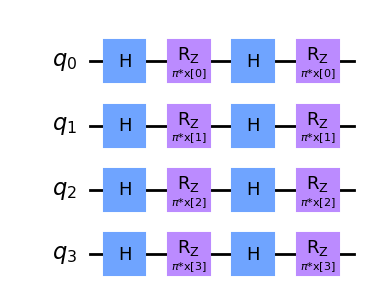

In [2]:
### Set up the encoder
X=ParameterVector('x',4)
encoder  = QuantumCircuit(4)
encoder.h([0,1,2,3])
encoder.rz(np.pi * X[0],0)
encoder.rz(np.pi * X[1],1)
encoder.rz(np.pi * X[2],2)
encoder.rz(np.pi * X[3],3)
encoder=encoder.compose(encoder)
encoder.draw(output='mpl',fold=-1)

In [3]:
from scipy.linalg import qr
from qiskit.quantum_info import Operator, SparsePauliOp
##Generate an n-point Test set and an n-point Training set
def generateData(delta,n):
    
    #random 16x16 Unitary 
    H = (np.random.randn(16, 16)+1j*np.random.randn(16, 16))/np.sqrt(2)
    Q, R = qr(H)
    R = np.diag(np.diag(R)/abs(np.diag(R)))
    U=Q.dot(R)
    V=Operator(U)
    
    #Pairity Function
    f = SparsePauliOp('ZZZZ').to_matrix()
    
    
    #Populate the data sets
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    while(len(train_x) < n or len(test_x )< n):
        
        x  = 2*np.random.random(4)-1 
        temp_qc = encoder.assign_parameters(x)
        val = Statevector(temp_qc).expectation_value(V.adjoint()@f@V).real
        if(val<-delta and len(train_x) < n and train_y.count(-1)< n//2):
            train_x.append(x)
            train_y.append(-1)
        elif(val>delta and len(train_x) < n and train_y.count(1)< n//2):
            train_x.append(x)
            train_y.append(1)
        
        x  = 2*np.random.random(4)-1
        temp_qc = encoder.assign_parameters(x)
        val = Statevector(temp_qc).expectation_value(V.adjoint()@f@V).real
        if(val<-delta and len(test_x )< n and test_y.count(-1)< n//2):
            test_x.append(x)
            test_y.append(-1)
        elif(val>delta and len(test_x )< n and test_y.count(1)< n//2):
            test_x.append(x)
            test_y.append(1)
    return test_x,test_y, train_x,train_y, V

In [4]:
### Generate the dataset
test_x,test_y,train_x,train_y,V = generateData(0.3,100)

print("Training Data:")
print("Plus: "+str(len([i for i in train_y if i==1])))
print("Minus: "+str(len([i for i in train_y if i==-1])))
print("------------")
print("Test Data:")
print("Plus: "+str(len([i for i in test_y if i==1])))
print("Minus: "+str(len([i for i in test_y if i==-1])))


Training Data:
Plus: 50
Minus: 50
------------
Test Data:
Plus: 50
Minus: 50


In [5]:
def getClassifier(layers=3):
    Classifier=QuantumCircuit(4)
    Theta = ParameterVector('θ', 8 * layers)
    for i in range(layers):
        Classifier.ry(Theta[8*i],0)
        Classifier.ry(Theta[8*i+1],1)
        Classifier.ry(Theta[8*i+2],2)
        Classifier.ry(Theta[8*i+3],3)
        Classifier.rz(Theta[8*i+4],0)
        Classifier.rz(Theta[8*i+5],1)
        Classifier.rz(Theta[8*i+6],2)
        Classifier.rz(Theta[8*i+7],3)
        if(i<layers-1):
            Classifier.cx(0,1)
            Classifier.cx(1,2)
            Classifier.cx(2,3)
            Classifier.cx(3,0)
    return Classifier
classifier = getClassifier(5)


In [6]:
val,params = VQC_optimize(train_x=train_x,train_y=train_y,classifier=classifier,encoder=encoder,iterations=100,save_dir="Log",name='KernelD')
theta = np.array(params)*np.pi/2

In [7]:
accuracy(classifier,encoder,theta,train_x,test_x,train_y,test_y)

(0.94, 0.92)